In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn import linear_model
from sklearn import decomposition

The file explain is a rtf file explaining which variables are numeric and which are categorical. There are 1765 variables, the first being ID and it's part in the explain file does not contain the target string 'the SPSS measurement level is'. The others' part contains either NOMINAL, ORDINAL or SCALE. Only SCALE is numeric.

column 'n1842' is epilepsy status

In [23]:
# file path of explain file
explain_path = '/Users/hung-yiwu/Documents/AC209a_project/data/ncds_sweep0-3/mrdoc/allissue/ncds0123_ukda_data_dictionary.rtf'

# open explain file
explain = open(explain_path, 'r')

# read the whole file as a single giant string
explain_text = explain.read()

# target string
target_string = 'the SPSS measurement level is'

# locate target string in the whole file
target_loc = [m.start() for m in re.finditer(target_string, explain_text)]

In [24]:
# file path of data file
data_path = './ncds_sweep0-3/tab/ncds0123.tab'

# read data file into Pandas DataFrame
# delimiter is tab
# use column 'ncdsid' as index
data = pd.read_csv(data_path, delimiter='\t').set_index('ncdsid')

In [25]:
# identify categorical variables by target strings in explain file
cat_col = []

for index, loc in enumerate(target_loc):
    # get feature character
    char = explain_text[loc+len(target_string)+10]
    
    if data.columns[index] == 'n1842':
        # response variable
        continue
    elif char == 'O' or char == 'o' or char == 'N' or char == 'n' \
        or 'region' in data.columns[index]:
        # it is SPSS data type ORDINAL or NOMINAL
        # it is categorical data
        cat_col.append(index)

print len(cat_col), 'categorical predictor variables'
print len(data.columns)-1-len(cat_col), 'numerical predictor variables'
print len(data.columns)-1, 'total predictor variables'

# calculate number of variables after dummy expansion
col_len = np.zeros(data.shape[1])

for index, col in enumerate( data.columns ):
    if index in cat_col:
        # categorical variable
        # require expansion
        col_len[index] = len( data[col].unique() )
    else:
        # numerical variable
        # does not require expansion
        col_len[index] = 1

print int( sum(col_len) )-1, 'predictor variables after dummy expansion'
print data.shape[0], 'observations'

1650 categorical predictor variables
113 numerical predictor variables
1763 total predictor variables
14517 predictor variables after dummy expansion
18558 observations


In [26]:
new_columns = []
sub_df_list = []

for index, col in enumerate(data.columns):
    if index in cat_col:
        # categorical variable
        # dummify
        dummies = pd.get_dummies(data[col])
        # append value
        sub_df_list.append( dummies )
        # append column name
        new_columns.extend([str(col)+'='+str(value) for value in data[col].unique()])
    else:
        # numeric variable
        # append value
        sub_df_list.append( data[col].apply(lambda x: 0 if x == ' ' else float(x)) )
        # append column name
        new_columns.append(col)
        
data_expanded = pd.concat( sub_df_list, axis=1 )
data_expanded.columns = new_columns

Pos. = 353	Variable = n1842	Variable label = 12D Epilepsy identification

This variable is  numeric, the SPSS measurement level is ORDINAL

SPSS user missing values = -1.0 thru -2.0

	Value label information for n1842
	Value = 1.0	Label = No convulsiv dis
	Value = 2.0	Label = Indef convls dis
	Value = 3.0	Label = Faints
	Value = 4.0	Label = Hysterical attck
	Value = 5.0	Label = Epilepsy
	Value = 6.0	Label = Unsubstan epilep
	Value = 7.0	Label = Febr convs-prob
	Value = 8.0	Label = Febr convs -pos
	Value = 9.0	Label = Not diag epilep
	Value = 10.0	Label = Febrile convuls
	Value = 11.0	Label = Breath-holding
	Value = 12.0	Label = Blank-spells
	Value = -1.0	Label = Nt epilepsy stdy
	Value = -2.0	Label = No NCDS1,NCDS2

In [27]:
# separate predictor and response variables
y = data_expanded['n1842'].values
x = data_expanded.drop('n1842', axis=1).values

In [28]:
# binary question: epilepsy or not
y_t = np.array( [1 if value == 5 else 0 for value in y] )

In [29]:
# reduce dimension by pca
# already did a full decomposition and decided to use first 4 principal components
# decomposition takes time so did not do it twice to show everything
pca_model = decomposition.PCA( n_components = 4)
x_t = pca_model.fit_transform(x)

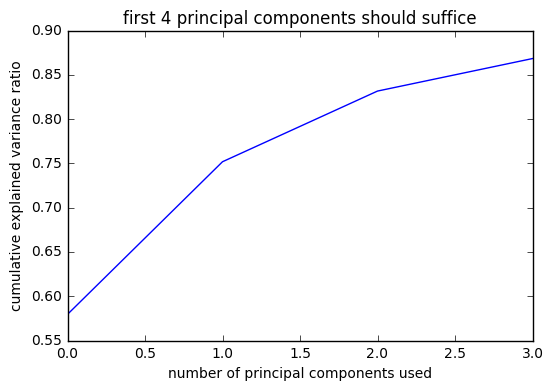

In [30]:
# visualize principal components contribution
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('number of principal components used')
plt.ylabel('cumulative explained variance ratio')
plt.title('first 4 principal components should suffice')
plt.show()

In [31]:
# classify seizure status by multi-class logistic regression with CV
model = linear_model.LogisticRegressionCV()
model.fit(x_t, y_t)
rsq = model.score(x_t, y_t)

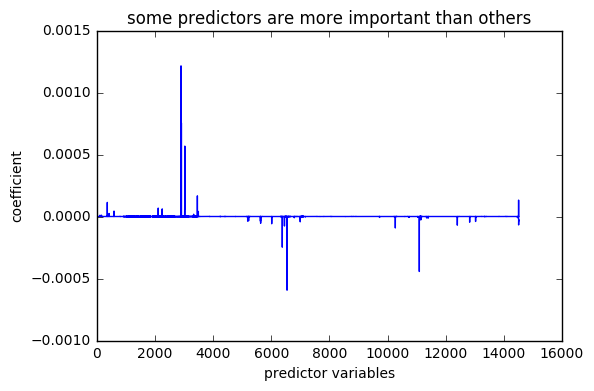

In [32]:
coef = model.coef_
pc = pca_model.components_
importance = np.sum( coef.reshape(4,-1)*pc, axis = 0 )
plt.plot( importance )
plt.xlabel('predictor variables')
plt.ylabel('coefficient')
plt.title('some predictors are more important than others')
plt.show()

In [33]:
# get variable list
var_list = data_expanded.drop('n1842', axis=1).columns

# get top three positive coef
top_pos_ind = np.argsort(importance)[-4:][:-1]
top_pos = list( var_list[top_pos_ind] )
print 'top positive variables'
print top_pos
print ''

# get top three negative coef
top_neg_ind = np.argsort(importance)[0:3]
top_neg = list( var_list[top_neg_ind] )
print 'top negative variables'
print top_neg

top positive variables
['n149', 'n59', 'n13']

top negative variables
['n870', 'n2104', 'n829']


n149: 1D Childs school attendance-% half-days

n59: 1S N of possible half-day attendances

n13: 1S % LEA which was comprehensive in 1974

n870: 2S Possible half-day school attendances

n2104: 3S No. pupils at present on school roll

n829: 2S Total number of childn on school roll

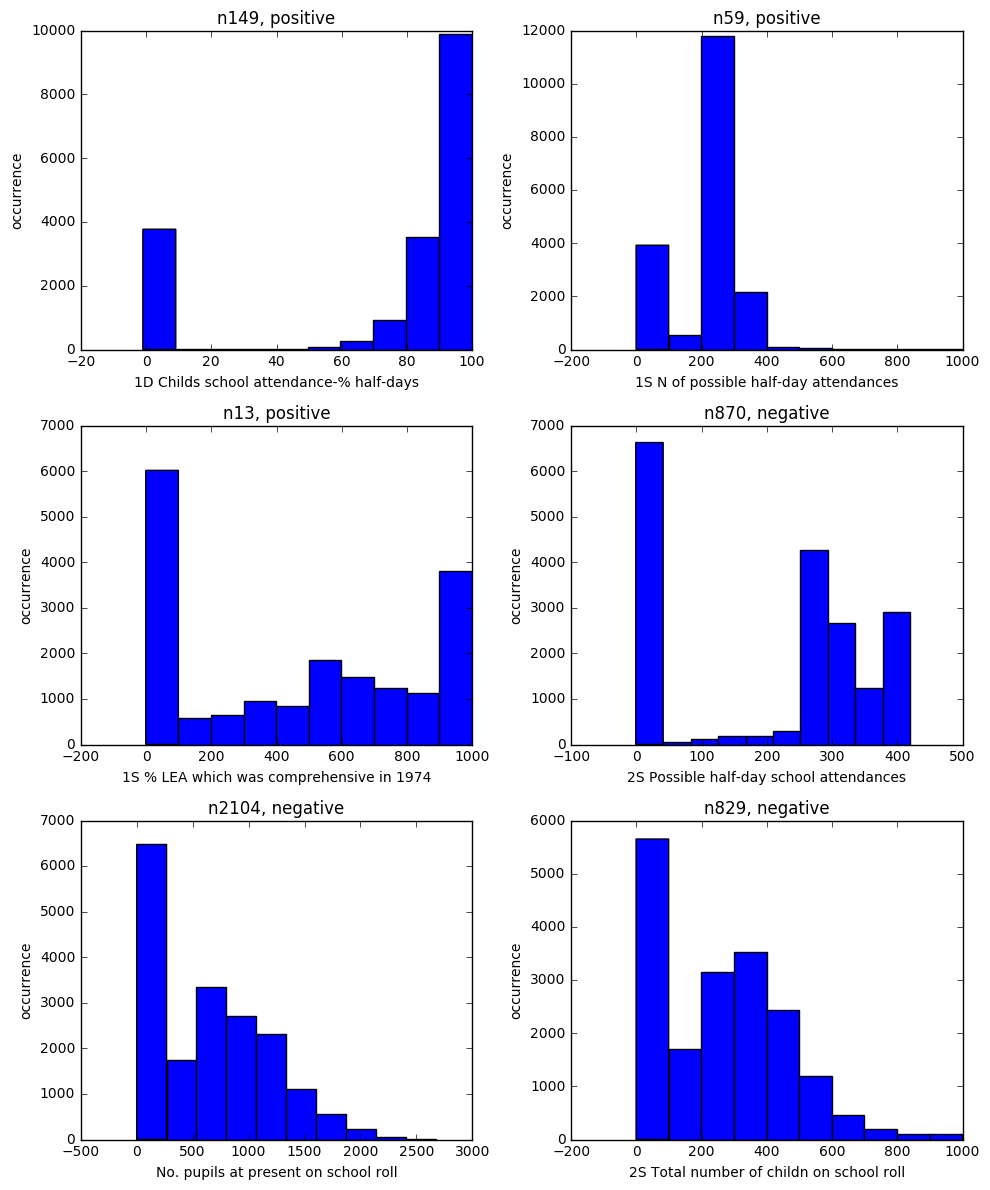

In [34]:
f = plt.figure( figsize = (10,12) )

ax1 = f.add_subplot(321)
ax1.hist( data_expanded['n149'].values )
ax1.set_xlabel('1D Childs school attendance-% half-days')
ax1.set_ylabel('occurrence')
ax1.set_title('n149, positive')

ax2 = f.add_subplot(322)
ax2.hist( data_expanded['n59'].values )
ax2.set_xlabel('1S N of possible half-day attendances')
ax2.set_ylabel('occurrence')
ax2.set_title('n59, positive')

ax3 = f.add_subplot(323)
ax3.hist( data_expanded['n13'].values )
ax3.set_xlabel('1S % LEA which was comprehensive in 1974')
ax3.set_ylabel('occurrence')
ax3.set_title('n13, positive')

ax4 = f.add_subplot(324)
ax4.hist( data_expanded['n870'].values )
ax4.set_xlabel('2S Possible half-day school attendances')
ax4.set_ylabel('occurrence')
ax4.set_title('n870, negative')

ax5 = f.add_subplot(325)
ax5.hist( data_expanded['n2104'].values )
ax5.set_xlabel('No. pupils at present on school roll')
ax5.set_ylabel('occurrence')
ax5.set_title('n2104, negative')

ax6 = f.add_subplot(326)
ax6.hist( data_expanded['n829'].values )
ax6.set_xlabel('2S Total number of childn on school roll')
ax6.set_ylabel('occurrence')
ax6.set_title('n829, negative')

f.tight_layout()
plt.show()

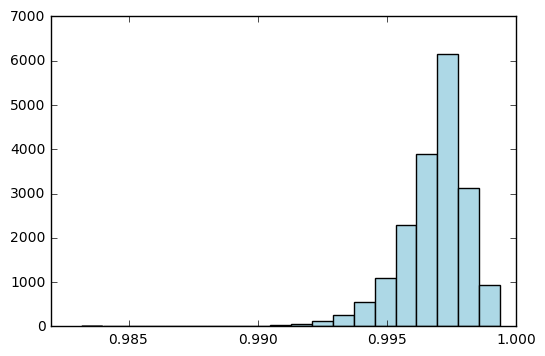

In [51]:
model.fit(x_t, y_t)
p =  model.predict_proba(x_t)[:,0]
plt.hist(p[p>0.5], color = 'lightblue', bins = 20)
plt.show()